In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

## Importing & Splitting Data

In [2]:
# data = np.genfromtxt(r"C:\Users\Vasco\Documents\Ms Data Science\3Semester\DATA\COVID2\MatLab Files\Supine\ALL_COVID2_SUPINE_PLUS_LABELS.csv", delimiter=',', skip_header=1, filling_values=-1)
Data = pd.read_csv(r"C:\Users\Vasco\Documents\Ms Data Science\3Semester\DATA\COVID2\MatLab Files\Supine\ALL_COVID2_SUPINE_PLUS_LABELS (agg).csv", sep=',')
# Remove Missing Values
Data = Data.dropna(axis=0)
X = Data.iloc[:,0:112]
# Remove non-numeric dtypes
# X.dtypes
X = X.select_dtypes(exclude='object')
# Normalize features
# names = X.columns
# X = pd.DataFrame(normalize(X), columns=names)
Y = Data.iloc[:,113]
# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

### Data cleaning, Redundant Features and Feature/Dimensionality Reduction

In [3]:
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

Which columns don't add any information? --> Index([], dtype='object')


<AxesSubplot:>

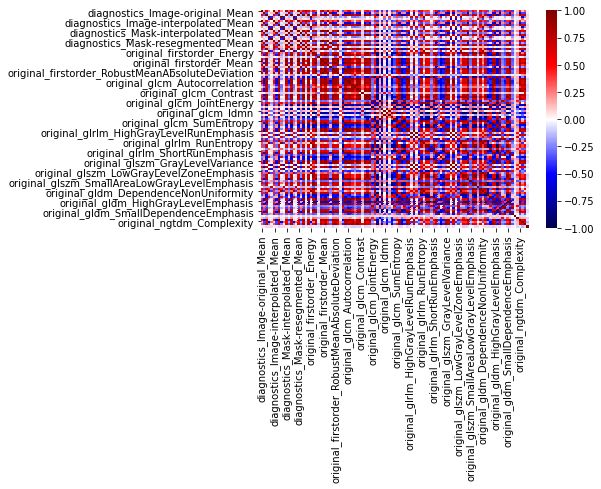

In [4]:
# Which columns don't add any information?
print(f'Which columns don\'t add any information? --> {X.columns[X.var(axis=0)==0]}')

# Check pairwise correlation between features (NOT PRACTICAL)
corr = X.corr(min_periods=2000)

# Check that using a heatmap correlation matrix
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='seismic', xticklabels=5, yticklabels=5)


In [5]:
# Check for multicolinearity between features using variance inflation factor (VIF). If the VIF is 1 then the features are non-colinear and as big as VIF gets the more colinear they are. Usually, for features with a VIF>5 something should be done (e.g. remove them or replace them with a Principle Component).
def calculate_vif_(X, thresh=5.0):
    '''
    This function takes a pandas DataFrame X and for each column computes the variance inflation factor (VIF) between itself and all the other columns. It then takes the column with the higher VIF value and removes it if the respective VIF is bigger then a pre-defined Threshold.
    This function returns a message saying which variables have been kept, as well as the resulting proned Pandas DataFrame.
    '''
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix) for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(f'dropping \'{X.iloc[:, variables].columns[maxloc]}\' at index: {str(maxloc)} with VIF: {max(vif)}')
            del variables[maxloc]
            dropped = True

    print(f'Remaining variables:\n{X.columns[variables]}')
    return X.iloc[:, variables]

X_VIF = calculate_vif_(X)

dropping 'diagnostics_Mask-original_VoxelNum' at index: 3 with VIF: inf
dropping 'original_glcm_ClusterTendency' at index: 38 with VIF: inf
dropping 'diagnostics_Image-interpolated_Maximum' at index: 6 with VIF: 1183073718.920012
dropping 'diagnostics_Image-original_Minimum' at index: 1 with VIF: 449640672.5531663
dropping 'diagnostics_Image-original_Maximum' at index: 1 with VIF: 333586184.1688689
dropping 'diagnostics_Mask-original_VolumeNum' at index: 1 with VIF: 196233426.70298976
dropping 'original_firstorder_Maximum' at index: 19 with VIF: 185287758.5602098
dropping 'original_glrlm_ShortRunHighGrayLevelEmphasis' at index: 64 with VIF: 102871793.90038912
dropping 'diagnostics_Mask-resegmented_Maximum' at index: 12 with VIF: 260022817.95511493
dropping 'original_glszm_HighGrayLevelZoneEmphasis' at index: 67 with VIF: 19059387.765449304
dropping 'diagnostics_Mask-resegmented_Mean' at index: 10 with VIF: 10000422.518487012
dropping 'original_firstorder_Variance' at index: 26 with VIF

In [6]:
# Split data into train & test sets
Xvif_train, Xvif_test, yvif_train, yvif_test = train_test_split(X_VIF, Y, test_size=0.2, random_state=123)

## Supervised Learning

In [7]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [8]:
# Using regression and then binning
models = [
          ('LinReg', LinearRegression()), 
          ('LassoReg', Lasso()),
          ('RidgeReg', Ridge())
        ]

for name, model in models:
    model.fit(X_train,y_train)
    y_predict = model.predict(X_test)
    # "Binning"
    y_predictB = y_predict.astype(int)
    print(f'{name}\n\tR-squared: {model.score(X_test, y_test):.5f}\tRMSE = {np.sqrt(np.mean((y_predict-y_test)**2)):.5f}\tRMSE(with Binning) = {np.sqrt(np.mean((y_predictB-y_test)**2)):.5f}')


LinReg
	R-squared: 0.33517	RMSE = 3.40235	RMSE(with Binning) = 3.45568
LassoReg
	R-squared: 0.17669	RMSE = 3.78621	RMSE(with Binning) = 3.82093
RidgeReg
	R-squared: 0.25414	RMSE = 3.60372	RMSE(with Binning) = 3.63438


In [9]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_validate

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.decomposition import PCA

In [10]:
# Percentage of the classes
print(round(Data['SET_PEEP_V'].value_counts()/2059*100,0))

# Since the dataset is heavily unbalanced I will apply weights to the classes for the models
class_weights = dict(max(Data['SET_PEEP_V'].value_counts())/Data['SET_PEEP_V'].value_counts())

14    38.0
12    14.0
16    13.0
18    12.0
10     6.0
20     3.0
8      3.0
22     3.0
24     3.0
6      2.0
17     2.0
15     0.0
38     0.0
Name: SET_PEEP_V, dtype: float64


## Classification

In [21]:
# Classifiers
# Log Reg, Random Forests, KN Class, SVM, Nayve-Bayesian, NN, Generalized linear reg
models = [
          ('LogReg', LogisticRegression(multi_class='ovr')),
          ('LogReg-W', LogisticRegression(multi_class='ovr', class_weight='balanced')), 
          ('RF', RandomForestClassifier(max_depth=4)),
          ('KNN', KNeighborsClassifier(n_neighbors=50)), # unbalanceness will always make majority voting fall into the predominant class
          ('SVM', SVC(decision_function_shape='ovr')),
          ('SVM-W', SVC(decision_function_shape='ovr', class_weight='balanced')),
          ('GNB', GaussianNB()),
          ('NN', MLPClassifier(hidden_layer_sizes=(200,13), solver='adam', activation='relu', random_state=123))
        ]

print('''
=============================================================================
##############################  ALL Variables  ##############################
=============================================================================''')
dfs = []
results = []
names = []
target_classes = np.unique(y_train).astype(str)

for name, model in models:
        kfold = KFold(n_splits=5, shuffle=False, random_state=12345)
        cv_results = cross_validate(model, X, Y, cv=kfold, scoring=['balanced_accuracy','precision_macro','recall_macro','f1_macro'], return_train_score=True)
        # clf = model.fit(X_train, y_train)
        # y_pred = clf.predict(X_test)
        # print(f'{name}\n{sk.metrics.classification_report(y_test, y_pred, target_names=target_classes)}')
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

final = pd.concat(dfs, ignore_index=True)
# display(final)
display(final.groupby(final.model).mean())

print('''
=============================================================================
##############################  VIF Variables  ##############################
=============================================================================''')
dfs = []
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, shuffle=False, random_state=12345)
    cv_results = cross_validate(model, X_VIF, Y, cv=kfold, scoring=['balanced_accuracy','precision_macro','recall_macro','f1_macro'], return_train_score=True)
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)

final = pd.concat(dfs, ignore_index=True)

display(final.groupby(final.model).mean().round(5))


##############################  ALL Variables  ##############################


,fit_time,score_time,test_balanced_accuracy,train_balanced_accuracy,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro
model,,,,,,,,,,
GNB,0.004883,0.004782,0.115525,0.128143,0.043629,0.044174,0.098051,0.128143,0.056815,0.062461
KNN,0.023317,0.027047,0.122433,0.085129,0.081250,0.083549,0.122433,0.085129,0.078498,0.056848
LogReg,0.271197,0.003757,0.115393,0.099554,0.042816,0.075441,0.103131,0.099554,0.058101,0.071300
LogReg-W,0.134612,0.003255,0.028844,0.156664,0.009332,0.018651,0.025505,0.156664,0.012027,0.022604
NN,5.821078,0.005218,0.117547,0.079487,0.045985,0.030145,0.117547,0.079487,0.064711,0.043654
RF,0.465880,0.012080,0.113562,0.141067,0.044041,0.495850,0.110337,0.141067,0.061350,0.148978
SVM,0.443708,0.080858,0.117547,0.079487,0.045985,0.030145,0.117547,0.079487,0.064711,0.043654
SVM-W,0.972468,0.086145,0.059486,0.169525,0.036210,0.070460,0.045664,0.169525,0.026116,0.029917



##############################  VIF Variables  ##############################


,fit_time,score_time,test_balanced_accuracy,train_balanced_accuracy,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro
model,,,,,,,,,,
GNB,0.00206,0.00378,0.11579,0.12155,0.05399,0.08388,0.09610,0.12155,0.05620,0.07436
KNN,0.00341,0.01381,0.11934,0.08586,0.09415,0.08693,0.11934,0.08586,0.07488,0.05831
LogReg,0.20306,0.00339,0.11292,0.08096,0.04863,0.04287,0.09709,0.08096,0.05903,0.05196
LogReg-W,0.07242,0.00336,0.04462,0.11593,0.00993,0.00753,0.04254,0.11593,0.01491,0.01243
NN,4.87653,0.00582,0.11755,0.07949,0.04599,0.03014,0.11755,0.07949,0.06471,0.04365
RF,0.20798,0.01176,0.12091,0.18247,0.07044,0.66433,0.10665,0.18247,0.06493,0.20603
SVM,0.09816,0.02167,0.11743,0.08386,0.04497,0.03784,0.11522,0.08386,0.06330,0.04925
SVM-W,0.20704,0.02297,0.07253,0.20740,0.02656,0.09422,0.05427,0.20740,0.02714,0.03800


In [12]:
#Where to prone the random forest trees
models = [
          ('RF03', RandomForestClassifier(max_depth=3)),
          ('RF04', RandomForestClassifier(max_depth=4)),    #Seems to be the best
          ('RF05', RandomForestClassifier(max_depth=5)),
          ('RF06', RandomForestClassifier(max_depth=6)),
          ('RF07', RandomForestClassifier(max_depth=7)),
          ('RF08', RandomForestClassifier(max_depth=8)),
          ('RF09', RandomForestClassifier(max_depth=9)),
          ('RF10', RandomForestClassifier(max_depth=10)),
        ]

dfs = []
results = []
names = []
target_classes = np.unique(y_train).astype(str)

for name, model in models:
        kfold = KFold(n_splits=5, shuffle=False, random_state=12345)
        cv_results = cross_validate(model, X, Y, cv=kfold, scoring=['balanced_accuracy','precision_macro','recall_macro','f1_macro'], return_train_score=True)
        # clf = model.fit(X_train, y_train)
        # y_pred = clf.predict(X_test)
        # print(f'{name}\n{sk.metrics.classification_report(y_test, y_pred, target_names=target_classes)}')
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

final = pd.concat(dfs, ignore_index=True)
# display(final)
display(final.groupby(final.model).mean())

,fit_time,score_time,test_balanced_accuracy,train_balanced_accuracy,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro
model,,,,,,,,,,
RF03,0.372662,0.011435,0.116584,0.114055,0.046231,0.270792,0.113103,0.114055,0.062837,0.104717
RF04,0.465348,0.011764,0.113780,0.138728,0.044155,0.491078,0.110524,0.138728,0.061513,0.144553
RF05,0.543666,0.012645,0.113550,0.186381,0.065674,0.645995,0.110305,0.186381,0.063485,0.222457
RF06,0.629036,0.013270,0.109923,0.280912,0.063492,0.791060,0.106855,0.280912,0.062471,0.358546
RF07,0.707735,0.012630,0.110942,0.378067,0.077129,0.856478,0.105856,0.378067,0.065012,0.471677
RF08,0.768930,0.013882,0.115248,0.516820,0.083267,0.958256,0.109796,0.516820,0.067962,0.624388
RF09,0.830755,0.013430,0.112502,0.643154,0.098801,0.965285,0.098170,0.643154,0.066400,0.742945
RF10,0.902175,0.013978,0.114523,0.753546,0.093565,0.974798,0.100751,0.753546,0.073765,0.835938


## Regression
### PCA

7PCs account for 0.880426 explaindevariance


,PC,explained_variance_ratio,Cumulative_explained_variance_ratio
0,1.0,0.481419,0.481419
1,2.0,0.128644,0.610062
2,3.0,0.083389,0.693451
3,4.0,0.071964,0.765415
4,5.0,0.055217,0.820632
5,6.0,0.034865,0.855497
6,7.0,0.024929,0.880426


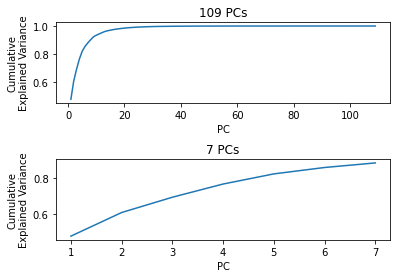

In [13]:
# Data needs to be centered before PCA
X0_train = X_train-np.mean(X_train, 0)
# How many features?
m = X_train.shape[1]
# Normalize
scaler = StandardScaler().fit(X0_train)
X0_train = scaler.transform(X0_train)
# Fit a PCA with as many PCs as there are features to investigate the explained variance
pca = PCA(n_components=m)
pca.fit(X0_train)
# print(pca.explained_variance_ratio_)
plt.figure(1)
plt.subplot(211)
plt.plot(np.linspace(1,m,m), np.cumsum(pca.explained_variance_ratio_))
plt.title(f'{m} PCs')
plt.xlabel('PC')
plt.ylabel('Cumulative\nExplained Variance')
plt.subplots_adjust(hspace=0.7)
# Fit a PCA with a more sensible number of PCs based on the explained variance
m=7
pca = PCA(n_components=m)
pca.fit(X0_train)
# print(pca.explained_variance_ratio_)
plt.subplot(212)
plt.plot(np.linspace(1,m,m), np.cumsum(pca.explained_variance_ratio_))
plt.title(f'{m} PCs')
plt.xlabel('PC')
plt.ylabel('Cumulative\nExplained Variance')

print(f'{m}PCs account for {sum(pca.explained_variance_ratio_):.6f} explaindevariance')
pd.DataFrame(np.array([np.linspace(1,m,m), pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_)]).T, columns=['PC','explained_variance_ratio','Cumulative_explained_variance_ratio'])

In [14]:
# PC Regression (PCR), Partial Least Squares (PLS), Canonical Correlation Analysis (CCA)
models = [
          ('LinReg', LinearRegression()), 
          ('LassoReg', Lasso()),
          ('RidgeReg', Ridge()),
          ('PCR', make_pipeline(StandardScaler(), PCA(n_components=m), LinearRegression())), 
          ('PLS', PLSRegression(n_components=m)),
          ('CCA', CCA(n_components=m)),
          ('RFR', RandomForestRegressor())
        ]

print('''
=============================================================================
##############################  ALL Variables  ##############################
=============================================================================''')
dfs = []
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, shuffle=False, random_state=12345)
    cv_results = cross_validate(model, X, Y, cv=kfold, scoring=['r2', 'neg_root_mean_squared_error'], return_train_score=True)
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)

final = pd.concat(dfs, ignore_index=True)

display(final.groupby(final.model).mean().round(5))

print('''
=============================================================================
##############################  VIF Variables  ##############################
=============================================================================''')
dfs = []
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, shuffle=False, random_state=12345)
    if (name=='PCR' or name=='PLS'):
        continue
    cv_results = cross_validate(model, X_VIF, Y, cv=kfold, scoring=['r2', 'neg_root_mean_squared_error'], return_train_score=True)
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)

final = pd.concat(dfs, ignore_index=True)

display(final.groupby(final.model).mean().round(5))

# for name, model in models:
#     model.fit(Xvif_train,yvif_train)
#     y_predict = model.predict(Xvif_test).flatten()
#     # "Binning"
#     y_predictB = y_predict.astype(int)
#     print(f'{name}')
#     print(f'\tR-squared: {model.score(Xvif_test, yvif_test):.5f}\tRMSE = {np.sqrt(np.mean((y_predict-yvif_test)**2)):.5f}\tRMSE(with Binning) = {np.sqrt(np.mean((y_predictB-yvif_test)**2)):.5f}')
#     plt.figure()
#     plt.scatter(y_predict, (y_predict - y_test), c='b')
#     plt.title(f'PEEP Level Residuals Plot - {name}')
#     plt.xlabel('PEEP Level (predicted)')
#     plt.ylabel('Residuals')



##############################  ALL Variables  ##############################


,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
model,,,,,,
CCA,0.05394,0.00165,-0.02152,0.00000,-3.64850,-3.74130
LassoReg,0.05415,0.00206,-0.09413,0.16047,-3.68242,-3.42205
LinReg,0.03358,0.00131,-0.75600,0.33430,-4.33833,-3.04522
PCR,0.02047,0.00152,-0.09031,0.07842,-3.67687,-3.58848
PLS,0.02089,0.00152,-1.09373,0.17779,-4.33893,-3.38596
RFR,7.47002,0.00973,-0.17938,0.93995,-3.71604,-0.91647
RidgeReg,0.00661,0.00140,-0.62337,0.24165,-4.13429,-3.24941



##############################  VIF Variables  ##############################


,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
model,,,,,,
CCA,0.00447,0.00093,-1.54519,-0.15711,-4.80829,-4.01729
LassoReg,0.00180,0.00149,-0.04348,0.04658,-3.65570,-3.65165
LinReg,0.00207,0.00139,-0.28854,0.07140,-3.87014,-3.60286
RFR,0.86149,0.01015,-0.08656,0.91679,-3.59524,-1.07786
RidgeReg,0.00229,0.00145,-0.19253,0.06135,-3.79488,-3.62252


### Cluster Analysis

In [15]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN

K-MEANS

Correlation (Pearson) coeficients between kmeans assigned clusters and features:
	diagnostics_Image-original_Mean: 0.16383959941684834
	diagnostics_Image-original_Minimum: -0.1393666158220881
	diagnostics_Image-original_Maximum: 0.3435199055968688
	diagnostics_Mask-original_VoxelNum: -0.022467000500522354
	diagnostics_Mask-original_VolumeNum: 0.014905813127178221
	diagnostics_Image-interpolated_Mean: 0.16420152386057693
	diagnostics_Image-interpolated_Minimum: -0.1393666158220881
	diagnostics_Image-interpolated_Maximum: 0.3435199055968688
	diagnostics_Mask-interpolated_VoxelNum: -0.022467000500522354
	diagnostics_Mask-interpolated_VolumeNum: 0.014905813127178221
	diagnostics_Mask-interpolated_Mean: 0.289419235922406
	diagnostics_Mask-interpolated_Minimum: -0.11353461006862643
	diagnostics_Mask-interpolated_Maximum: 0.34352239232574927
	diagnostics_Mask-resegmented_VoxelNum: -0.02170006095463395
	diagnostics_Mask-resegmented_VolumeNum: 0.014948293047114217
	diagnostics_Mask-res

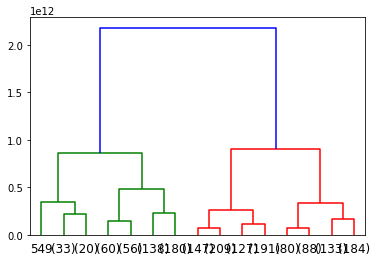

In [16]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    scipy.cluster.hierarchy.dendrogram(linkage_matrix, **kwargs)



H_clust = sk.cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None)
H_clust.fit(X_train)
plot_dendrogram(H_clust, truncate_mode='level', p=3)


#####################################################################################################
Nclusters = np.unique(Y).size

kmeans = KMeans(n_clusters=Nclusters)
kmeans.fit(X_train)
pred_kmeans = kmeans.labels_

# Is there correlation between the assigned cluter and the features' values?
X_train_Kmeans = X_train.copy(deep=False)
X_train_Kmeans.insert(len(X_train.columns), 'kmeans_clust', pred_kmeans)

print('K-MEANS\n\nCorrelation (Pearson) coeficients between kmeans assigned clusters and features:')
for col in X_train_Kmeans.columns:
    print(f'\t{col}: {X_train_Kmeans["kmeans_clust"].corr(X_train_Kmeans[col])}')

# Now I want to compare the unsupervised learned labels to the actual PEEP Level labels set
# perhaps make a dictionary to match cluster to label and then kmeans.labels_==y_train
print(f'\tReal Labels: {X_train_Kmeans["kmeans_clust"].corr(Y)}')


#####################################################################################################

dbs = DBSCAN()
dbs.fit(X_train)
pred_dbs = dbs.labels_

# Is there correlation between the assigned cluter and the features' values?
X_train_dbs = X_train.copy(deep=False)
X_train_dbs.insert(len(X_train.columns), 'dbs_clust', pred_dbs)

print('\n\nDB-SCAN\n\nCorrelation (Pearson) coeficients between DBS assigned clusters and features:')
for col in X_train_dbs.columns:
    print(f'\t{col}: {X_train_dbs["dbs_clust"].corr(X_train_dbs[col])}')

# Now I want to compare the unsupervised learned labels to the actual PEEP Level labels set
# perhaps make a dictionary to match cluster to label and then kmeans.labels_==y_train
print(f'\tReal Labels: {X_train_dbs["dbs_clust"].corr(Y)}')

## With Binary labels representing Good PEEP level (1) or Bad PEEP level (0)

In [17]:
Data2 = pd.read_csv(r"C:\Users\Vasco\Documents\Ms Data Science\3Semester\DATA\COVID2\MatLab Files\Supine\ALL_COVID2_SUPINE_PLUS_LABELS_binary (agg).csv", sep=',')
# Remove Missing Values
Data2 = Data2.dropna(axis=0)
X2 = Data2.iloc[:,0:112]
# Remove non-numeric dtypes
# X.dtypes
X2 = X2.select_dtypes(exclude='object')
# Normalize features
# names = X.columns
# X = pd.DataFrame(normalize(X), columns=names)
Y2 = Data2.iloc[:,114]

In [18]:
# Classifiers
# Log Reg, Random Forests, KN Class, SVM, Nayve-Bayesian, NN, Generalized linear reg
models = [
          ('LogReg', LogisticRegression(multi_class='ovr')), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier(n_neighbors=20)), # unbalanceness will always make majority voting fall into the predominant class
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('NN', MLPClassifier(hidden_layer_sizes=(100,2), random_state=123))
        ]

dfs = []
results = []
names = []
target_classes = np.unique(y_train).astype(str)

for name, model in models:
        kfold = KFold(n_splits=5, shuffle=False, random_state=12345)
        cv_results = cross_validate(model, X2, Y2, cv=kfold, scoring=['balanced_accuracy', 'f1'], return_train_score=True)
        # clf = model.fit(X_train, y_train)
        # y_pred = clf.predict(X_test)
        # print(f'{name}\n{sk.metrics.classification_report(y_test, y_pred, target_names=target_classes)}')
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

final = pd.concat(dfs, ignore_index=True)

final.groupby(final.model).mean()

,fit_time,score_time,test_balanced_accuracy,train_balanced_accuracy,test_f1,train_f1
model,,,,,,
GNB,0.005198,0.002394,0.499117,0.506580,0.015251,0.041798
KNN,0.022979,0.018991,0.500000,0.500000,0.000000,0.000000
LogReg,0.021307,0.001994,0.499171,0.500392,0.000000,0.002326
NN,3.291391,0.003544,0.500000,0.500000,0.000000,0.000000
RF,0.762353,0.011536,0.498639,1.000000,0.000000,1.000000
SVM,0.089140,0.021297,0.500000,0.500000,0.000000,0.000000


In [19]:
# PC Regression (PCR), Partial Least Squares (PLS), Canonical Correlation Analysis (CCA)
models = [
          ('LinReg', LinearRegression()), 
          ('LassoReg', Lasso()),
          ('RidgeReg', Ridge()),
          ('PCR', make_pipeline(StandardScaler(), PCA(n_components=m), LinearRegression())), 
          ('PLS', PLSRegression(n_components=m)),
          ('CCA', CCA(n_components=m))
        ]

print('''
=============================================================================
##############################  ALL Variables  ##############################
=============================================================================''')
dfs = []
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, shuffle=False, random_state=12345)
    cv_results = cross_validate(model, X2, Y2, cv=kfold, scoring=['r2', 'explained_variance', 'neg_root_mean_squared_error'], return_train_score=True)
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)

final = pd.concat(dfs, ignore_index=True)

display(final.groupby(final.model).mean().round(5))

print('''
=============================================================================
##############################  VIF Variables  ##############################
=============================================================================''')
dfs = []
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, shuffle=False, random_state=12345)
    cv_results = cross_validate(model, X_VIF, Y2, cv=kfold, scoring=['r2', 'explained_variance', 'neg_root_mean_squared_error'], return_train_score=True)
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)

final = pd.concat(dfs, ignore_index=True)

display(final.groupby(final.model).mean().round(5))


##############################  ALL Variables  ##############################


,fit_time,score_time,test_r2,train_r2,test_explained_variance,train_explained_variance,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
model,,,,,,,,
CCA,0.05012,0.00139,-0.00149,0.00000,0.00000,0.00000,-0.30752,-0.30766
LassoReg,0.07880,0.00186,0.02488,0.04491,0.02731,0.04491,-0.30346,-0.30067
LinReg,0.03265,0.00157,-0.03378,0.08497,-0.03063,0.08497,-0.31226,-0.29430
PCR,0.02200,0.00183,0.02159,0.03114,0.02617,0.03114,-0.30396,-0.30283
PLS,0.01972,0.00190,0.03271,0.05670,0.03490,0.05670,-0.30222,-0.29881
RidgeReg,0.00624,0.00161,0.01493,0.06789,0.01684,0.06789,-0.30500,-0.29703



##############################  VIF Variables  ##############################


,fit_time,score_time,test_r2,train_r2,test_explained_variance,train_explained_variance,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
model,,,,,,,,
CCA,0.00357,0.00140,-0.43743,-0.33374,-0.43290,-0.33374,-0.36770,-0.35489
LassoReg,0.00309,0.00100,0.01159,0.01512,0.01283,0.01512,-0.30553,-0.30532
LinReg,0.00177,0.00099,0.01001,0.03076,0.01210,0.03076,-0.30573,-0.30289
PCR,0.00713,0.00137,0.00888,0.02559,0.01101,0.02559,-0.30591,-0.30370
PLS,0.00718,0.00100,0.01085,0.03076,0.01298,0.03076,-0.30561,-0.30289
RidgeReg,0.00141,0.00092,0.00147,0.02557,0.00250,0.02557,-0.30696,-0.30370


## Using the params data